In [1]:
# default_exp data

# Data

> Tools to help construct datasets, which may be related to loading, processing, or encoding data.

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [46]:
# export
import boto3
from collections import deque
from functools import partial
import mmh3
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from tqdm.auto import tqdm
import warnings

from htools import auto_repr, save, load, func_name, ifnone, tolist, \
    BasicPipeline

In [66]:
# Only needed for testing.
from collections import Counter
from itertools import chain
import numpy as np
from torch.utils.data import DataLoader

from htools import eprint, assert_raises

In [6]:
# export
def probabilistic_hash_item(x, n_buckets, mode=int, n_hashes=3):
    """Slightly hacky way to probabilistically hash an integer by
    first converting it to a string.
    
    Parameters
    ----------
    x: int
        The integer or string to hash.
    n_buckets: int
        The number of buckets that items will be mapped to. Typically 
        this would occur outside the hashing function, but since 
        the intended use case is so narrow here it makes sense to me 
        to include it here.
    mode: type
        The type of input you want to hash. This is user-provided to prevent
        accidents where we pass in a different item than intended and hash 
        the wrong thing. One of (int, str). When using this inside a
        BloomEmbedding layer, this must be `int` because there are no
        string tensors. When used inside a dataset or as a one-time
        pre-processing step, you can choose either as long as you
        pass in the appropriate inputs.
    n_hashes: int
        The number of times to hash x, each time with a different seed.
        
    Returns
    -------
    list[int]: A list of integers with length `n_hashes`, where each integer
        is in [0, n_buckets).
    """
    # Check type to ensure we don't accidentally hash Tensor(5) instead of 5.
    assert isinstance(x, mode), f'Input `x` must have type {mode}.'
    return [mmh3.hash(str(x), i, signed=False) % n_buckets 
            for i in range(n_hashes)]

In [7]:
# export
def probabilistic_hash_tensor(x_r2, n_buckets, n_hashes=3, pad_idx=0):
    """Hash a rank 2 LongTensor.
    
    Parameters
    ----------
    x_r2: torch.LongTensor
        Rank 2 tensor of integers. Shape: (bs, seq_len)
    n_buckets: int
        Number of buckets to hash items into (i.e. the number of 
        rows in the embedding matrix). Typically a moderately large
        prime number, like 251 or 997.
    n_hashes: int
        Number of hashes to take for each input index. This determines
        the number of rows of the embedding matrix that will be summed
        to get the representation for each word. Typically 2-5.
    pad_idx: int or None
        If you want to pad sequences with vectors of zeros, pass in an
        integer (same as the `padding_idx` argument to nn.Embedding).
        If None, no padding index will be used. The sequences must be
        padded before passing them into this function.
        
    Returns
    -------
    torch.LongTensor: Tensor of indices where each row corresponds
        to one of the input indices. Shape: (bs, seq_len, n_hashes)
    """
    return torch.tensor(
        [[probabilistic_hash_item(x.item(), n_buckets, int, n_hashes) 
          if x != pad_idx else [pad_idx]*n_hashes for x in row]
         for row in x_r2]
    )

In [ ]:
sents = [
    'I walked to the store so I hope it is not closed.',
    'The theater is closed today and the sky is grey.',
    'His dog is brown while hers is grey.'
]
labels = [0, 1, 1]

In [ ]:
class Data(Dataset):
    
    def __init__(self, sentences, labels, seq_len):
        x = [s.split(' ') for s in sentences]
        self.w2i = self.make_w2i(x)
        self.seq_len = seq_len
        self.x = self.encode(x)
        self.y = torch.tensor(labels)
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.y)
    
    def make_w2i(self, tok_rows):
        return {k: i for i, (k, v) in 
                enumerate(Counter(chain(*tok_rows)).most_common(), 1)}
    
    def encode(self, tok_rows):
        enc = np.zeros((len(tok_rows), self.seq_len), dtype=int)
        for i, row in enumerate(tok_rows):
            trunc = [self.w2i.get(w, 0) for w in row[:self.seq_len]]
            enc[i, :len(trunc)] = trunc
        return torch.tensor(enc)

We construct a toy dataset with a vocabulary of size 23. In reality, you might wish to lowercase text or use a better tokenizer, but this is sufficient for the purposes of demonstration.

In [ ]:
ds = Data(sents, labels, 10)
len(ds.w2i)

23

In [ ]:
dl = DataLoader(ds, batch_size=3)
x, y = next(iter(dl))
x, y

(tensor([[ 2,  5,  6,  3,  7,  8,  2,  9, 10,  1],
         [13, 14,  1, 15, 16, 17,  3, 18,  1,  4],
         [19, 20,  1, 21, 22, 23,  1,  4,  0,  0]]), tensor([0, 1, 1]))

In [ ]:
x.shape

torch.Size([3, 10])

We hash each word index 4 times, as specified by the `n_hashes` parameter in `probabilistic_hash_tensor`. Notice that we only use 7 buckets, meaning the embedding matrix will have 7 rows rather than 23 (not counting a padding row).

In [ ]:
x_hashed = probabilistic_hash_tensor(x, n_buckets=7, n_hashes=4)
print('x shape:', x.shape)
print('x_hashed shape:', x_hashed.shape)

x shape: torch.Size([3, 10])
x_hashed shape: torch.Size([3, 10, 4])


Below, each row of 4 numbers encodes a single word.

In [ ]:
x_hashed

tensor([[[2, 0, 2, 2],
         [1, 6, 2, 4],
         [2, 0, 1, 4],
         [5, 2, 6, 5],
         [1, 5, 1, 3],
         [0, 4, 0, 0],
         [2, 0, 2, 2],
         [2, 4, 0, 2],
         [3, 4, 4, 6],
         [5, 0, 3, 6]],

        [[5, 4, 4, 2],
         [5, 3, 3, 1],
         [5, 0, 3, 6],
         [2, 1, 1, 1],
         [2, 4, 4, 4],
         [2, 4, 2, 6],
         [5, 2, 6, 5],
         [3, 5, 0, 0],
         [5, 0, 3, 6],
         [1, 5, 2, 6]],

        [[5, 5, 3, 4],
         [4, 5, 5, 1],
         [5, 0, 3, 6],
         [6, 2, 0, 6],
         [4, 2, 6, 1],
         [3, 6, 1, 6],
         [5, 0, 3, 6],
         [1, 5, 2, 6],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]])

See how each word is mapped to a list of 4 indices.

In [ ]:
for word, i in zip(sents[0].split(' '), x[0]):
    print(word, probabilistic_hash_item(i.item(), 7, int, 4))

I [2, 0, 2, 2]
walked [1, 6, 2, 4]
to [2, 0, 1, 4]
the [5, 2, 6, 5]
store [1, 5, 1, 3]
so [0, 4, 0, 0]
I [2, 0, 2, 2]
hope [2, 4, 0, 2]
it [3, 4, 4, 6]
is [5, 0, 3, 6]


Notice that hashing the words directly is also possible, but the resulting hashes will be **different** than if hashing after encoding words as integers. This is fine as long as you are consistent.

In [ ]:
for row in [s.split(' ') for s in sents]:
    eprint(list(zip(row, (probabilistic_hash_item(word, 11, str) for word in row))))
    print()

 0: ('I', [0, 5, 5])
 1: ('walked', [2, 5, 1])
 2: ('to', [10, 4, 6])
 3: ('the', [4, 1, 4])
 4: ('store', [4, 6, 3])
 5: ('so', [7, 8, 8])
 6: ('I', [0, 5, 5])
 7: ('hope', [1, 2, 7])
 8: ('it', [3, 9, 0])
 9: ('is', [3, 1, 3])
10: ('not', [6, 10, 4])
11: ('closed.', [3, 6, 10])

 0: ('The', [1, 6, 9])
 1: ('theater', [8, 10, 2])
 2: ('is', [3, 1, 3])
 3: ('closed', [5, 5, 0])
 4: ('today', [3, 10, 8])
 5: ('and', [7, 2, 4])
 6: ('the', [4, 1, 4])
 7: ('sky', [1, 2, 9])
 8: ('is', [3, 1, 3])
 9: ('grey.', [7, 6, 7])

 0: ('His', [0, 10, 3])
 1: ('dog', [8, 6, 6])
 2: ('is', [3, 1, 3])
 3: ('brown', [9, 8, 9])
 4: ('while', [9, 2, 8])
 5: ('hers', [0, 5, 4])
 6: ('is', [3, 1, 3])
 7: ('grey.', [7, 6, 7])



Below, we show that we can obtain unique representations for >99.9% of words in a vocabulary of 30,000 words with a far smaller embedding matrix. The number of buckets is the number of rows in the embedding matrix.

In [ ]:
def unique_combos(tups):
    return len(set(tuple(sorted(x)) for x in tups))

In [ ]:
def hash_all_idx(vocab_size, n_buckets, n_hashes):
    return [probabilistic_hash_item(i, n_buckets, int, n_hashes) 
            for i in range(vocab_size)]

In [ ]:
vocab_size = 30_000
buckets2hashes = {127: 5,
                  251: 4,
                  997: 3,
                  5_003: 2}
for b, h in buckets2hashes.items():
    tups = hash_all_idx(vocab_size, b,  h)
    unique = unique_combos(tups)
    print('\n\nBuckets:', b, '\nHashes:', h, '\nUnique combos:', unique,
          '\n% unique:', round(unique/30_000, 4))



Buckets: 127 
Hashes: 5 
Unique combos: 29998 
% unique: 0.9999


Buckets: 251 
Hashes: 4 
Unique combos: 29996 
% unique: 0.9999


Buckets: 997 
Hashes: 3 
Unique combos: 29997 
% unique: 0.9999


Buckets: 5003 
Hashes: 2 
Unique combos: 29969 
% unique: 0.999


## Datasets

In [8]:
@auto_repr
class LazyDataset(Dataset):
    """Lazily load batches from an enormous dataframe that can't fit into 
    memory.
    """

    def __init__(self, df_path, length, shuffle, chunksize=1_000, 
                 c=2, classes=('neg', 'pos'), **kwargs):
        """
        Parameters
        ----------
        df_path: str
            File path of dataframe to load.
        length: int
            Number of rows of data to use. This is required so that we don't 
            have to go through the whole file and count the number of lines,
            which can be enormous with a big dataset. It also makes it easy to
            work with a subset (the data should already be shuffled, so 
            choosing the top n rows is fine).
        shuffle: bool
            If True, shuffle the data in each chunk. Note that if batch size
            is close to chunk size, this will have minimal effect. If possible,
            the training set should therefore load as large a chunk as 
            possible if we want to shuffle the data. Shuffling is unnecessary 
            for the validation set.
        chunksize: int
            Number of rows of df to load at a time. This should usually 
            be significantly larger than the batch size in order to retain
            some randomness in the batches.
        c: int
            Number of classes. Used if training with FastAI.
        classes: iterable
            List of tuple of class names. Used if training with FastAI.
        kwargs: any
            Additional keyword arguments to pass to `read_csv`, eg. 
            compression='gzip'.
        """
        if length < chunksize:
            warnings.warn('Total # of rows < 1 full chunk. LazyDataset may '
                          'not be necessary.')

        self.length = length
        self.shuffle = shuffle
        self.chunksize = chunksize
        self.df_path = df_path
        self.df = None
        self.chunk = None
        self.chunk_idx = None
        self.df_kwargs = kwargs
        
        # Additional attributes required by FastAI. 
        # c: Number of classes in model.
        self.c = c
        self.classes = list(classes)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        """Because not all indices are loaded at once, we must do shuffling
        in the dataset rather than the dataloader (e.g. if the loader randomly
        samples index 5000 but we have indices 0-500 loaded, it will be
        unavailable).

        Parameters
        ----------
        idx: int
            Retrieve item i in dataset.

        Returns
        -------
        tuple[np.array]: x array, y array
        """
        # Load next chunk of data if necessary. Must specify nrows, otherwise
        # we will chunk through the whole file.
        if not self.chunk_idx:
            while True:
                try:
                    self.chunk = self.df.get_chunk()
                    break
                except (AttributeError, StopIteration):
                    self.df = pd.read_csv(self.df_path, engine='python',
                                          chunksize=self.chunksize,
                                          nrows=len(self),
                                          **self.df_kwargs)

            self.chunk_idx = self.chunk.index.values
            if self.shuffle: np.random.shuffle(self.chunk_idx)
            self.chunk_idx = deque(self.chunk_idx)
            
        *x, y = self.chunk.loc[self.chunk_idx.popleft()].values
        return np.array(x), y.astype(float)

In [10]:
class ImageMixer:
    """The transformation that powers MixupDS.

    Inspired by the "Visual-Spatial - Entangled Figures" task here:
    http://www.happy-neuron.com/brain-games/visual-spatial/entangled-figures

    The key idea: when a human plays the happy neuron task, it is much easier
    when viewing an entanglement of objects they recognize (e.g. bicycle, leaf,
    etc.) than of random scribbles. I noticed that for the harder levels, my
    strategy was to try to quickly identify a couple distinctive features, then
    search for them in the individual images once they appeared. This quick
    feature extraction seems very close to what we want to achieve during the
    pre-training step.
    """

    def __init__(self, n=3, a=5, b=8, dist=None, **kwargs):
        """
        Parameters
        ----------
        n: int
            Number of images to use as inputs. With the current implementation,
            the constructed image will use exactly 2 of these. The rest will
            be negatives (zero weight).
        a: int
            Parameter in beta distribution.
        b: int
            Parameter in beta distribution.
        dist: torch.distribution
            This can be anything with a "sample()" method that generates a
            random value between 0 and 1. By default, we use a Beta
            distribution. If one is passed in, a and b are ignored.
        kwargs: any
            Makes it easier to use in `get_databunch` function. Extra kwargs
            are ignored.
        """
        assert n >= 2, 'n must be >=2 so we can combine images.'

        self.dist = dist or torch.distributions.beta.Beta(a, b)
        self.n = n

    def transform(self, *images):
        """Create linear combination of images.

        Parameters
        ----------
        images: torch.tensors

        Returns
        -------
        tuple(torch.tensor): First item is (n_channel, h, w*self.n), meaning
        images are horizontally stacked. The first of these is the new image.
        The second item is the rank 1 tensor of weights used to generate the
        combination. These will serve as labels in our self-supervised task.
        """
        w = self._generate_weights()
        return (self._combine_images(images, w), *images), w

    def _generate_weights(self):
        """
        Returns
        -------
        weights: torch.Tensor
            Vector of length self.n. Exactly 2 of these values are
            nonzero and they sum to 1. This will be used to compute a linear
            combination of a row of images.
        """
        weights = np.zeros(self.n)
        p = self.dist.sample()
        indices = np.random.choice(self.n, size=2, replace=False)
        weights[indices] = p, 1 - p
        return torch.tensor(weights, dtype=torch.float)

    def _combine_images(self, images, weights):
        """Create linear combination of multiple images.

        Parameters
        ----------
        images: torch.Tensor
        weights: torch.Tensor
            Vector with 1 value for each image. Exactly 2 of these values are
            nonzero and they sum to 1. I.e. if we have 3 images a, b, and c,
            weights would look something like [0, .3, .7].

        Returns
        -------
        torch.tensor: Shape (channels, height, width), same as each of the
            input images.
        """
        images = torch.stack(images, dim=0)
        # 3 new dimensions correspond to (c, h, w), NOT self.n.
        return (weights[:, None, None, None] * images).sum(0).float()

In [11]:
# export
def plot_images(images, titles=None, nrows=None, figsize=None, 
                tight_layout=True, title_colors=None):
    nrows = nrows or int(np.ceil(np.sqrt(len(images))))
    titles = ifnone(titles, [None] * len(images))
    colors = ifnone(title_colors, ['black'] * len(images))
    figsize = figsize or (nrows*2, nrows*2)
    fig, ax = plt.subplots(nrows, nrows, figsize=figsize)
    for axi, img, title, color in zip(ax.flatten(), images, titles, colors):
        axi.imshow(img.permute(1, 2, 0))
        axi.set_title(title, color=color)
        axi.set_axis_off()
    if tight_layout: plt.tight_layout()
    plt.show()

In [51]:
# export
class RandomTransform:
    """Wrap a function to create a data transform that occurs with some
    probability p.
    """

    def __init__(self, func, p=.5):
        """
        Parameters
        ----------
        func: function
            Transforms an input tensor (x) in some way. X will be the first
            argument passed in but the function can accept additional
            arguments.
        p: float
            Between 0 and 1, determines the likelihood that func will be
            applied to any input x.
        """
        self.func = func
        self.p = p

    def __call__(self, x, *args, **kwargs):
        """Additional args and kwargs are forwarded to self.func."""
        if np.random.uniform() < self.p: x = self.func(x, *args, **kwargs)
        return x

    def __repr__(self):
        return f'{type(self).__name__}({func_name(self.func)}, p={self.p})'

In [52]:
# export
class RandomPipeline(BasicPipeline):
    """Create a pipeline of callables that are applied in sequence, each with
    some random probability p (this can be the same or different for each 
    step). This is useful for on-the-fly data augmentation (think in the
    __getitem__ method of a torch Dataset).
    """
    
    def __init__(self, *transforms, p=.5):
        """
        Parameters
        ----------
        transforms: callable
            Functions or callable classes that accept a single argument (use
            functools.partial if necessary). They will be applied in the order
            you pass them in.
        p: float or Iterable[float]
            Probability that each transform will be applied. If a single 
            float, each transform will have the same probability. If a list,
            its length msut match the number of transforms passed in: p[0] 
            will be assigned to transforms[0], p[1] to transforms[1], and so 
            on.
        """
        p = tolist(p, transforms, error_message='p must be a float or a list '
                   'with one float for each transform.')
        if any(n <= 0 or n > 1 for n in p):
            raise ValueError('p must be in range (0, 1]. I.E. you can choose '
                             'to always apply a transform, but if you never '
                             'want to apply it there\'s no need to include '
                             'it in the pipeline.')
        
        super().__init__(*[RandomTransform(t, p_) 
                           for t, p_ in zip(transforms, p)])
        
    @classmethod
    def from_dict(cls, t2p):
        """
        Parameters
        ----------
        t2p: dict[callable, float]
            Maps transform to its corresponding probability.
            
        Examples
        --------
        transforms = {times_3: .33,
                      to_string: 1.0,
                      dashed_join: .67,
                      to_upper: .95}
        pipeline = RandomPipeline.from_dict(transforms)
        """
        return cls(*t2p.keys(), p=t2p.values())

Below, we define a few toy functions to demonstrate how we can alter an input string. In practice, we'd use more useful transformations like the ones defined in `incendio.nlp`, e.g. `ParaphraseTransform`.

In [53]:
def to_upper(t):
    return t.upper()

def times_3(t):
    return t * 3

def join(t, sep='---'):
    return sep.join(t)

In [54]:
text = 'dog'
pipeline = RandomPipeline(to_upper, times_3, join)
pipeline

RandomPipeline(
	RandomTransform(to_upper, p=0.5),
	RandomTransform(times_3, p=0.5),
	RandomTransform(join, p=0.5)
)

In [57]:
for i in range(5):
    print(pipeline(text))

d---o---g
dog
D---O---G---D---O---G---D---O---G
D---O---G---D---O---G---D---O---G
DOGDOGDOG


In [64]:
pipeline = RandomPipeline(to_upper, times_3, join, p=[1., .4, 1])

for i in range(5):
    print(pipeline(text))

D---O---G---D---O---G---D---O---G
D---O---G
D---O---G---D---O---G---D---O---G
D---O---G
D---O---G


In [74]:
with assert_raises(ValueError):
    pipeline = RandomPipeline(join, p=0)

As expected, got ValueError(p must be in range (0, 1]. I.E. you can choose to always apply a transform, but if you never want to apply it there's no need to include it in the pipeline.).


In [68]:
with assert_raises(AssertionError):
    pipeline = RandomPipeline(to_upper, times_3, join, p=[.2, 1])

As expected, got AssertionError(p must be a float or a list with one float for each transform.).


In [73]:
transforms = {times_3: .33,
              join: .67,
              to_upper: .95}
pipeline = RandomPipeline.from_dict(transforms)

for i in range(5):
    print(pipeline(text))

D---O---G
D---O---G
D---O---G---D---O---G---D---O---G
DOG
D---O---G


## File Handling

In [ ]:
# export
class BotoUploader:
    """Uploads files to S3. Built as a public alternative to Accio. Note to 
    self: the interfaces are not identical so be careful to know which you're
    using.
    """
    
    def __init__(self, bucket, verbose=True):
        """
        Parameters
        ----------
        bucket: str
            Name of s3 bucket to upload to. For a single project, I generally
            stick to a single bucket so we can usually keep this fixed. We can
            always change the attribute later if necessary.
        verbose: bool
            If True, print message when downloading each file.
        """
        self.s3 = boto3.resource('s3')
        self.bucket = bucket
        self.verbose = verbose
        
    def upload_file(self, path, s3_dir='', retain_tree=True):
        """Upload a single local file. By default, its path in S3 will be the 
        same as its local path. Usually, this means your S3 bucket will have a 
        single directory called "data" which corresponds exactly to your local 
        "data" directory.
        
        Parameters
        ----------
        path: str or Path
            Local path to the file to upload. This must be relative to the 
            project root directory (e.g. "data/models/v1/model.gz").
        s3_dir: str
            If provided, this will pre prepended to each path: {s3_dir}/{path}.
            Otherwise, s3 paths will be the same as local paths.
        retain_tree: bool
            If True, the local file structure will be retained. Otherwise,
            only the base name is kept. All four combinations of retain_tree 
            (True/False) and s3_dir (empty/non-empty) are supported.
        """
        path = str(path)
        s3_path = self._convert_local_path(path, s3_dir, retain_tree)
        if self.verbose: print(f'Uploading {path} -> {s3_path}.')
        self.s3.meta.client.upload_file(path, self.bucket, s3_path)
        
    def upload_files(self, paths, s3_dir='', retain_tree=True):
        """Upload multiple files. Currently does not support parallelized
        uploads: need to figure out a workaround because self.s3 cannot be
        pickled.
        
        Parameters
        ----------
        paths: Iterable[str or Path]
            Sequence of file paths to upload.
        s3_dir: str
            If provided, this will pre prepended to each path: {s3_dir}/{path}.
            Otherwise, s3 paths will be the same as local paths.
        retain_tree: bool
            If True, the local file structure will be retained. Otherwise,
            only the base name is kept. All four combinations of retain_tree 
            (True/False) and s3_dir (empty/non-empty) are supported.
        """
        for p in paths:
            self.upload_file(p, s3_dir=s3_dir, retain_tree=retain_tree)
            
    def upload_folder(self, dirname, s3_dir, retain_tree=True, recurse=True,
                      keep_fn=None):
        """Upload all files in a directory.
        
        Parameters
        ----------
        dirname: str or Path
            Directory to upload.
        s3_dir: str
            If provided, this will pre prepended to each path: {s3_dir}/{path}. 
            Otherwise, s3 paths will be the same as local paths.
        retain_tree: bool
            If True, the local file structure will be retained. Otherwise,
            only the base name is kept. When uploading recursively, we require
            that the file tree is retained.
        recurse: bool
            If True, upload all files in subdirectories as well.
        keep_fn: None or callable
            If provided, this should be a function that accepts a filename as
            input and returns a boolean specifying whether to include it in the
            upload or not. For example:
            
            lambda x: os.path.splitext(x)[-1] != '.pkl'
            
            keeps all files except those with an '.pkl' extension. 
        """
        if recurse and not retain_tree:
            raise ValueError('retain_tree must be True when uploading '
                             'recursively.')
        pat = os.path.join(str(dirname), '**' if recurse else '*')
        # glob's recursive option only has an effect when using '**'.
        paths = (o for o in glob(pat, recursive=True) if os.path.isfile(o))
        if keep_fn: paths = filter(keep_fn, paths)
        self.upload_files(paths, s3_dir, retain_tree)
            
    def _convert_local_path(self, path, s3_dir='', retain_tree=True):
        """Convert local path to s3 path. See public methods for parameter
        documentation.
        """
        path = path if retain_tree else os.path.basename(path)
        return os.path.join(s3_dir, path)

In [ ]:
up = BotoUploader('gg-datascience')

In [ ]:
ft = up._convert_local_path('data/v1/history.csv')
tt = up._convert_local_path('data/v1/history.csv', 'hmamin')
tf = up._convert_local_path('data/v1/history.csv', 'hmamin', retain_tree=False)
ff = up._convert_local_path('data/v1/history.csv', retain_tree=False)

print('No S3 prefix, Yes retain file tree:\n' + ft)
print('\nYes S3 prefix, Yes retain file tree:\n' + tt)
print('\nYes S3 prefix, No retain file tree:\n' + tf)
print('\nNo S3 prefix, No retain file tree:\n' + ff)

No S3 prefix, Yes retain file tree:
data/v1/history.csv

Yes S3 prefix, Yes retain file tree:
hmamin/data/v1/history.csv

Yes S3 prefix, No retain file tree:
hmamin/history.csv

No S3 prefix, No retain file tree:
history.csv


## Plotting

In [34]:
# export
def plot_images(images, titles=None, nrows=None, figsize=None, 
                tight_layout=True, title_colors=None):
    """Plot a grid of images.
    
    Parameters
    ----------
    images: Iterable
        List of tensors/arrays to plot.
    titles: Iterable[str] or None
        Title for each subplot. Must be same length and order as `images`.
    nrows: int or None
        If provided, this manually sets the number of rows in the grid.
    figsize: tuple[int] or None
        Determines size of plot. By default, we double the number of rows and
        columns, respectively, to get dimensions.
    tight_layout: bool
        Often helps matplotlib formatting when we have many images.
    title_colors: Iterable[str] or None
        If provided, this should have the same length as `titles` and 
        `images`. It will be used to determine the color of each title (see
        PredictionExaminer in incendio.core for an example).
    """
    nrows = nrows or int(np.ceil(np.sqrt(len(images))))
    titles = ifnone(titles, [None] * len(images))
    colors = ifnone(title_colors, ['black'] * len(images))
    figsize = figsize or (nrows*2, nrows*2)
    fig, ax = plt.subplots(nrows, nrows, figsize=figsize)
    for axi, img, title, color in zip(ax.flatten(), images, titles, colors):
        axi.imshow(np.transpose(img, (1, 2, 0)))
        axi.set_title(title, color=color)
        axi.set_axis_off()
    if tight_layout: plt.tight_layout()
    plt.show()

Below, we demonstrate plotting a list of images stored as numpy arrays in a grid.

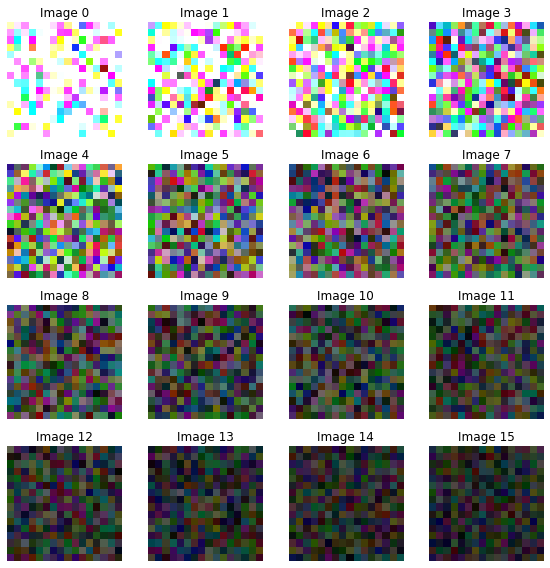

In [42]:
images = [np.clip(5 * np.random.uniform(size=(3, 16, 16)) / i, 0, 1)
          for i in range(1, 17)]
plot_images(images, titles=[f'Image {i}' for i in range(16)])

Here is a similar example showcasing the title color functionality. Notice we can use tensors here too.

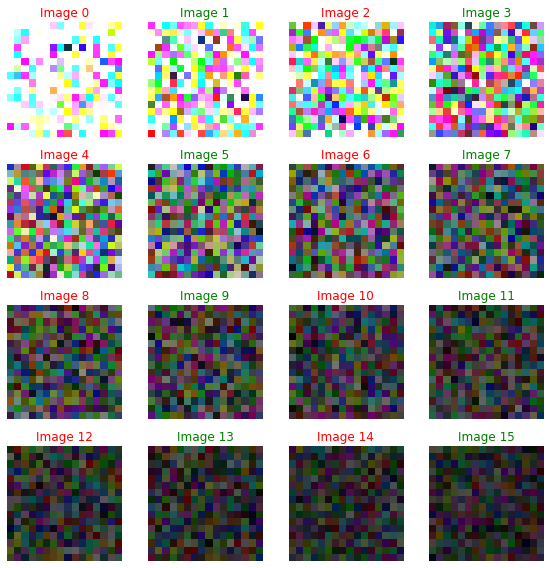

In [44]:
images = [torch.clamp(5 * torch.rand(3, 16, 16) / i, 0, 1)
          for i in range(1, 17)]
plot_images(images, titles=[f'Image {i}' for i in range(16)], 
            title_colors=['red' if i%2 == 0 else 'green' for i in range(16)])